# Initial things to do

## Check your GPU

In [1]:
# Check the properties of the assigned GPU

!nvidia-smi

Mon Jun 20 21:07:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount Google Drive

Connect your code with your Google drive account

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Import libraries

In [3]:
# Install required libraries
!pip install -q datasets transformers

     |████████████████████████████████| 362 kB 5.3 MB/s 
     |████████████████████████████████| 4.4 MB 66.3 MB/s 
     |████████████████████████████████| 212 kB 70.7 MB/s 
     |████████████████████████████████| 140 kB 77.1 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 27.6 MB/s 
     |████████████████████████████████| 596 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 67.6 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 
     |████████████████████████████████| 144 kB 72.9 MB/s 
     |████████████████████████████████| 271 kB 72.0 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import os, shutil
import numpy as np
import pandas as pd
from glob import glob
from functools import partial
from tqdm.notebook import tqdm
from itertools import cycle, islice

from sklearn.model_selection import train_test_split

from PIL import Image as PILImage
import matplotlib.pyplot as plt
import cv2

import datasets
from datasets import load_dataset
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from transformers import (ViTFeatureExtractor, ViTForImageClassification,
                          ConvNextFeatureExtractor, ConvNextForImageClassification,
                          DefaultDataCollator)
import albumentations as A



## Set initial variables

In [5]:
checkpoint_model_folder = 'content/saved_models/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Get your data

We will read our data and store it into a pandas dataframe for an easy managing

### Option 1: Load from HuggingFace datasets

In [6]:
data = load_dataset('food101', split="train[:5000]")

print(data)
print('')
print(data.features['label'].names)


Using custom data configuration default


Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.
Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi

### Option 2: Get your dataset from Kaggle

[How to download a dataset from Kaggle](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

First you have to download your API credentials and upload it to Google Colab

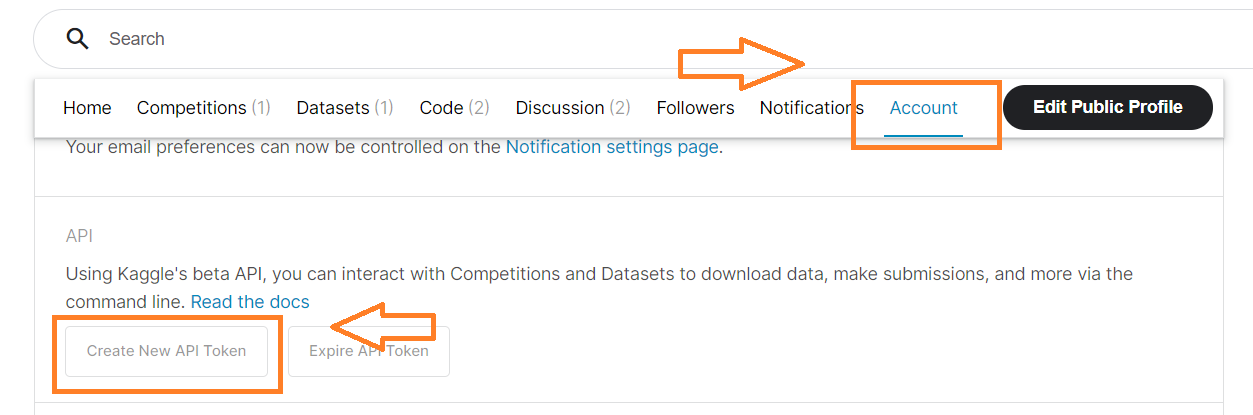

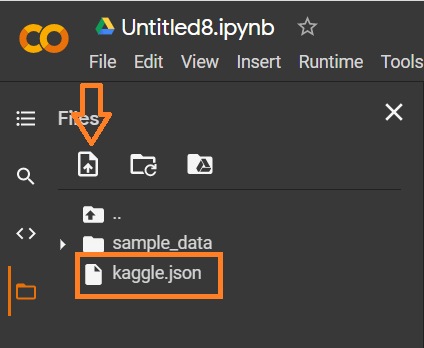

Then you have to install required libraries and configure everything

In [ ]:
!pip install kaggle

In [ ]:
# Copy the “kaggle.json” into this new directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Allocate the required permission for this file.
!chmod 600 ~/.kaggle/kaggle.json

Now, we are ready for downloading the dataset

In [ ]:
# Download dataset from kaggle webpage
!kaggle datasets download <your-dataset-name>

## Create a dictionary for mapping labels

Create a dictionary that maps a label name to an integer and vice versa. The mapping will help the model recover the label name from the label number:

In [7]:
""" Create a dictionary for mapping categorical true labels """

labels = data.features['label'].names
# print(labels)

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

display(label2id)

{'apple_pie': '0',
 'baby_back_ribs': '1',
 'baklava': '2',
 'beef_carpaccio': '3',
 'beef_tartare': '4',
 'beet_salad': '5',
 'beignets': '6',
 'bibimbap': '7',
 'bread_pudding': '8',
 'breakfast_burrito': '9',
 'bruschetta': '10',
 'caesar_salad': '11',
 'cannoli': '12',
 'caprese_salad': '13',
 'carrot_cake': '14',
 'ceviche': '15',
 'cheese_plate': '17',
 'cheesecake': '16',
 'chicken_curry': '18',
 'chicken_quesadilla': '19',
 'chicken_wings': '20',
 'chocolate_cake': '21',
 'chocolate_mousse': '22',
 'churros': '23',
 'clam_chowder': '24',
 'club_sandwich': '25',
 'crab_cakes': '26',
 'creme_brulee': '27',
 'croque_madame': '28',
 'cup_cakes': '29',
 'deviled_eggs': '30',
 'donuts': '31',
 'dumplings': '32',
 'edamame': '33',
 'eggs_benedict': '34',
 'escargots': '35',
 'falafel': '36',
 'filet_mignon': '37',
 'fish_and_chips': '38',
 'foie_gras': '39',
 'french_fries': '40',
 'french_onion_soup': '41',
 'french_toast': '42',
 'fried_calamari': '43',
 'fried_rice': '44',
 'frozen

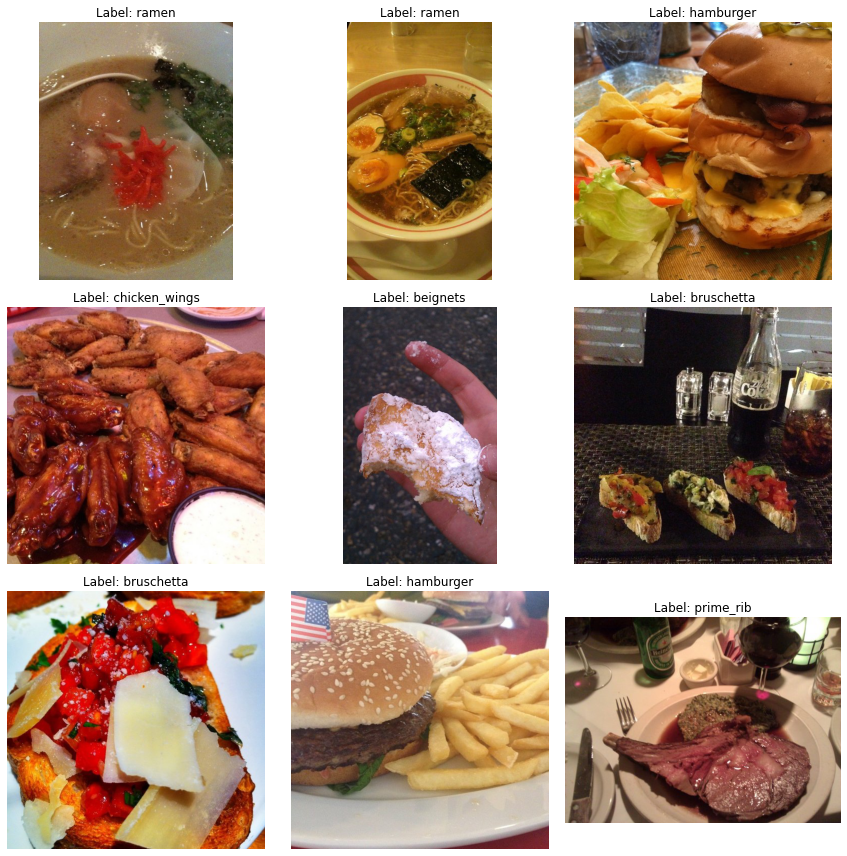

In [8]:
''' Sanity check. Display a grid of images '''

fig, axes = plt.subplots(3,3,figsize=(12,12))
shuffled_data = data.shuffle(seed=9)

for i, item in enumerate(shuffled_data):
    if i==9: break
    ax = axes[i//3, i%3]
    ax.imshow(item['image'])
    ax.axis('off')

    label_id = str(item['label'])
    ax.set_title('Label: {}'.format(id2label[label_id]))

plt.tight_layout()
plt.show()

## Split your data into train, val

In [13]:
splitted_data = data.train_test_split(test_size=0.2)
train_ds = splitted_data['train']
valtest_ds = splitted_data['test']

splitted_data = valtest_ds.train_test_split(test_size=0.5)
val_ds = splitted_data['train']
test_ds = splitted_data['test']

print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 500
})
Dataset({
    features: ['image', 'label'],
    num_rows: 500
})


## Load feature extractor and model

We will use ConvNext model from [HuggingFace implementation](https://huggingface.co/docs/transformers/model_doc/convnext).

The ConvNeXT model was proposed in A ConvNet for the 2020s and it is a pure convolutional model (ConvNet), inspired by the design of Vision Transformers, that claims to outperform them.

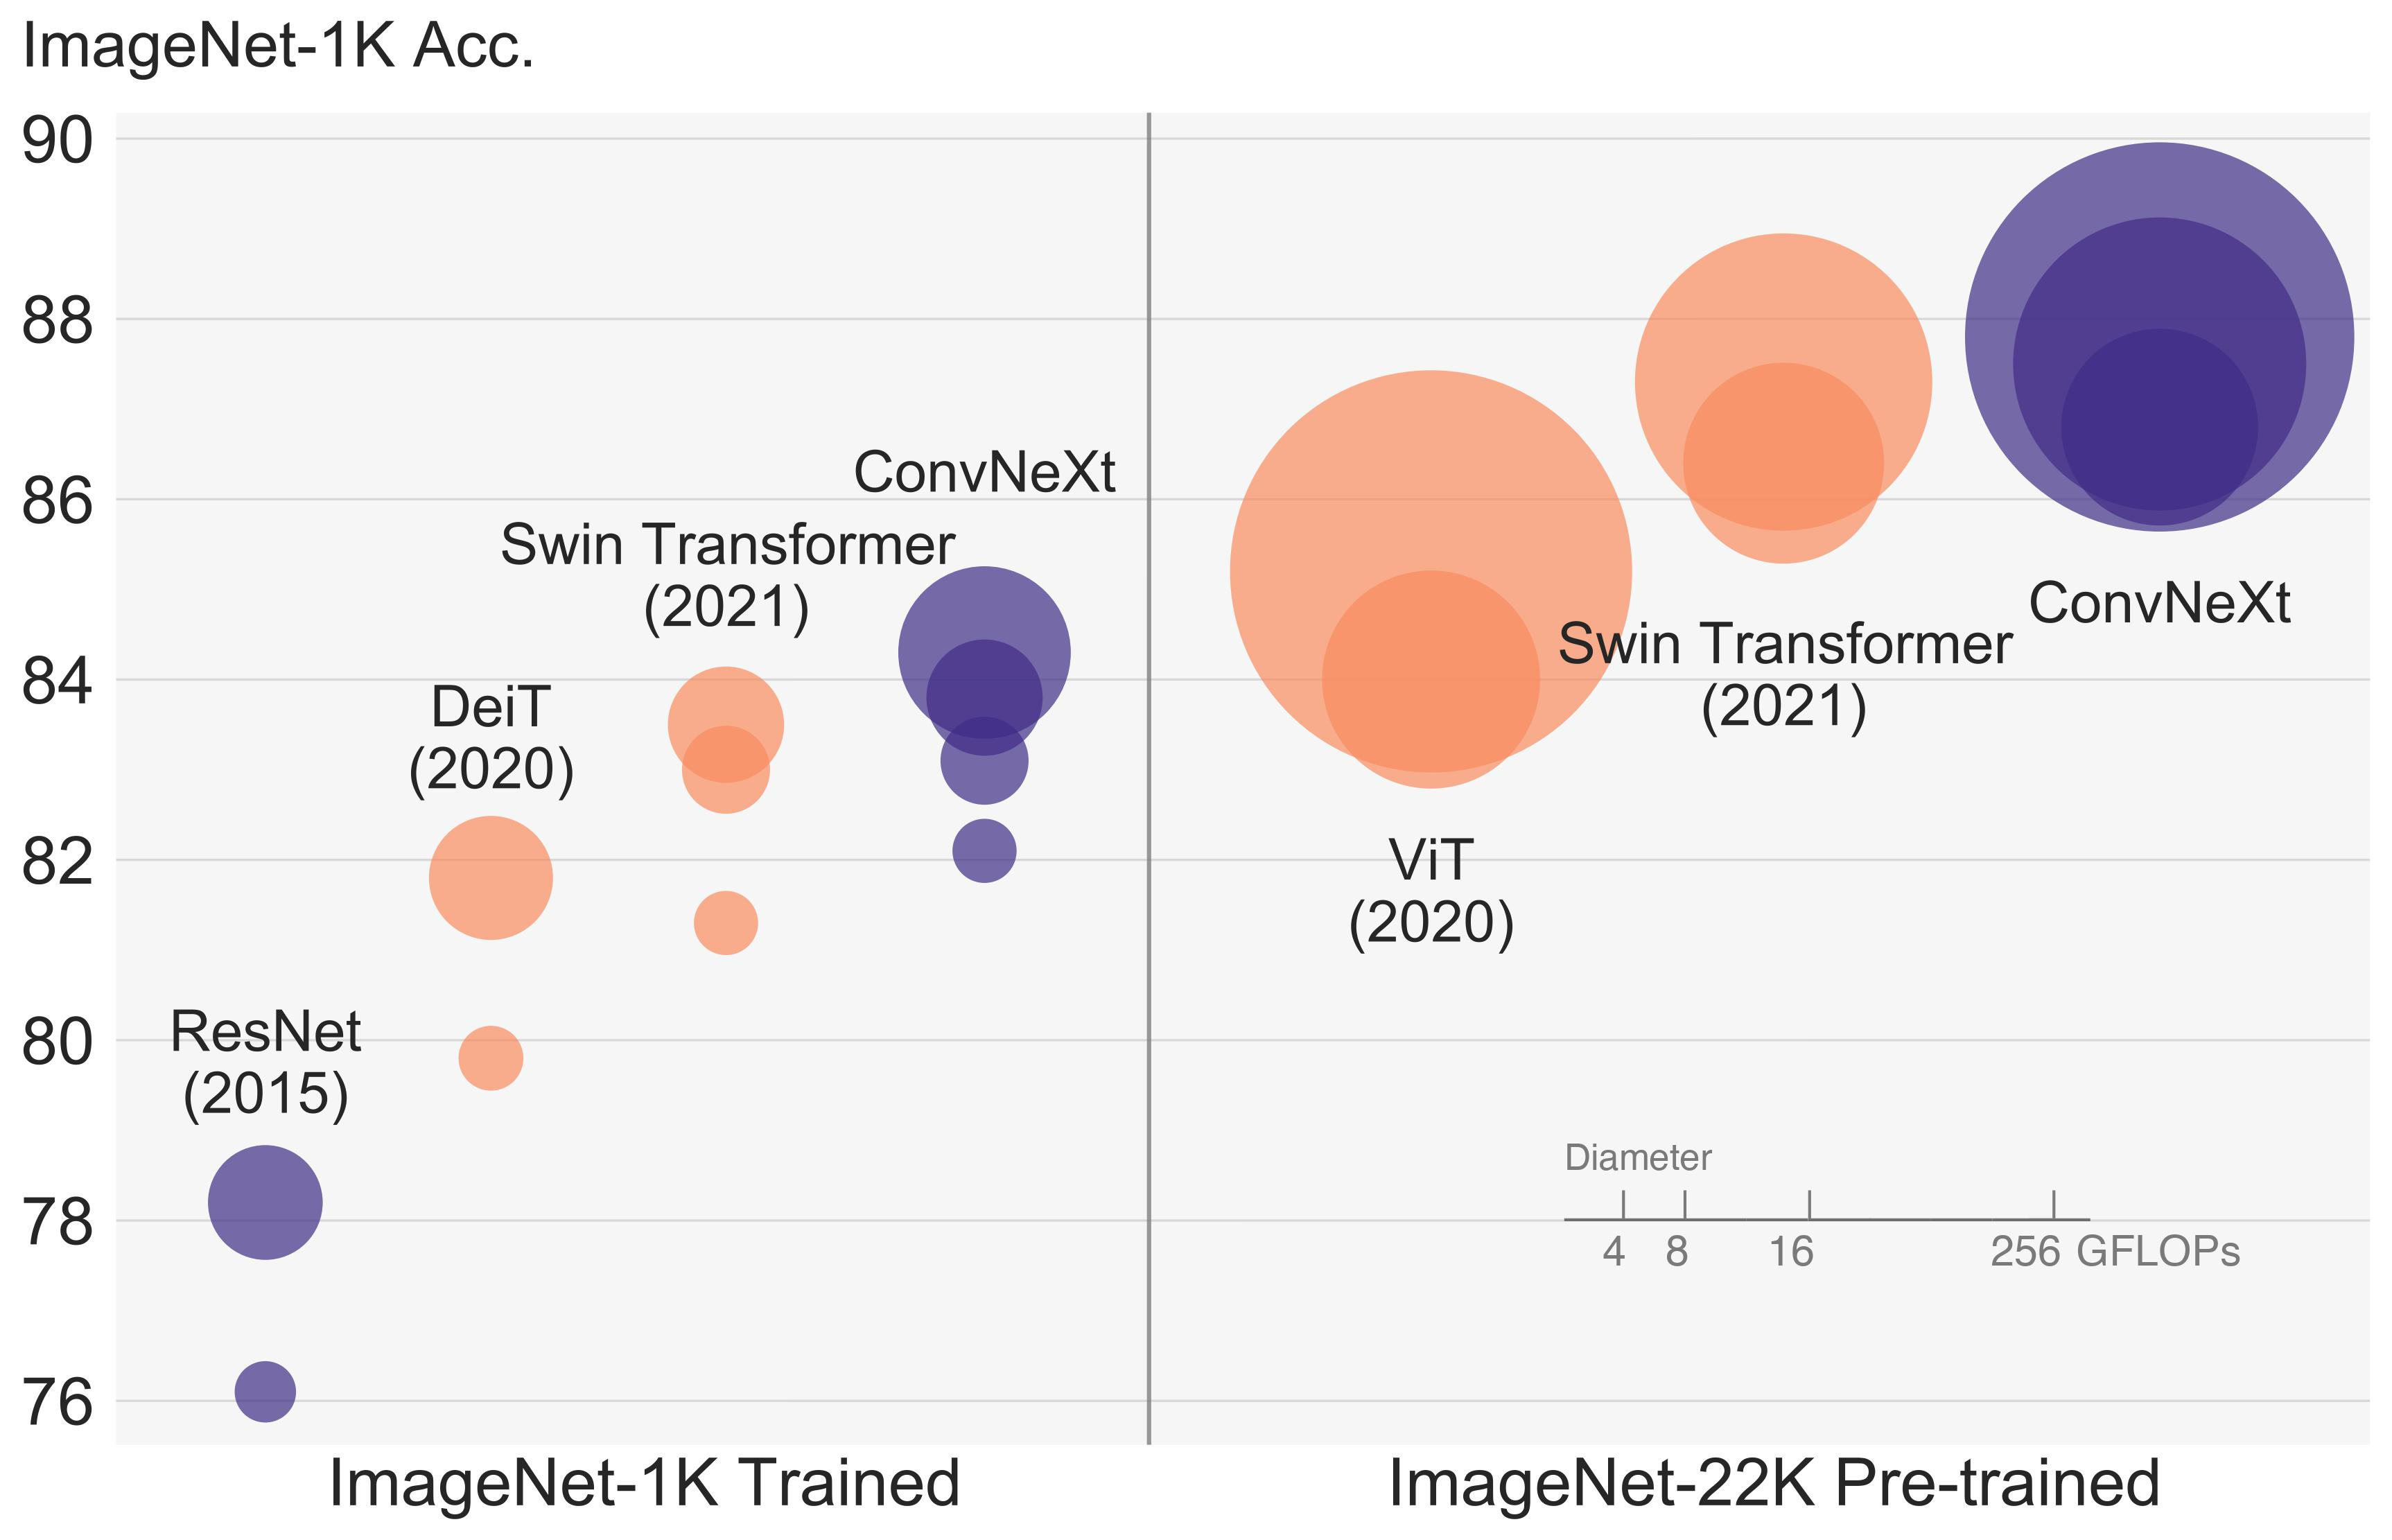

In [10]:
model_path = 'facebook/convnext-tiny-224'

# Load feature extractor component
feature_extractor = ConvNextFeatureExtractor.from_pretrained(model_path)
print(feature_extractor)

# Load model from pretrained
model = ConvNextForImageClassification.from_pretrained(model_path,
                                                    label2id=label2id,
                                                    id2label=id2label,
                                                    num_labels=len(labels),
                                                    ignore_mismatched_sizes = True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
                                                    )

# Send model to your device
model = model.to(device)
print(model.config)

Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/109M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextConfig {
  "_name_or_path": "facebook/convnext-tiny-224",
  "architectures": [
    "ConvNextForImageClassification"
  ],
  "depths": [
    3,
    3,
    9,
    3
  ],
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_sizes": [
    96,
    192,
    384,
    768
  ],
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "10": "bruschetta",
    "100": "waffles",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "2": "baklava",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",
    "25": "club_sandwich",
    "26": "crab_cakes",
    "27": "creme_brulee",
    "28": "croque_madame",
    "29": "cup_cakes",
    "3": "beef_carpaccio",
    "30": "deviled_eggs",
    "31": "donuts",
    "32": "dumplings",
  

## Create dataset objects

We will create datasets for each subgroup of images, with the format required by the trainer object

## Define data-augmentation pipelines

In [14]:
normalize = T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

_torch_train_transforms = T.Compose(
        [
            T.RandomResizedCrop(feature_extractor.size),
            T.ColorJitter(brightness=.5, hue=.3),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.ToTensor(),
        ])

_torch_val_transforms = T.Compose(
        [
            T.Resize(feature_extractor.size),
            T.ToTensor(),
        ])

def torchvision_dataset_transform(examples, train=False, size=(224,224)):
    if train:
        examples["pixel_values"] = [_torch_train_transforms(image.convert("RGB")) for image in examples["image"]]
    else:
        examples["pixel_values"] = [_torch_val_transforms(image.convert("RGB")) for image in examples["image"]]
    
    del examples["image"]

    input = feature_extractor(examples["pixel_values"], return_tensors='pt')
    input["label"] = examples["label"]
    return input

# # Set transforms:  Datasets set_transform apply the transforms on-the-fly.
train_ds.set_transform(partial(torchvision_dataset_transform, train=True))
val_ds.set_transform(partial(torchvision_dataset_transform, train=False))
test_ds.set_transform(partial(torchvision_dataset_transform, train=False))

In [ ]:
# """ Sanity check. Check a testing data augmentation tranformation"""

# test_transforms = T.Compose(
#         [
#             # T.Pad(30),
#             T.Resize(feature_extractor.size),
#             T.RandomResizedCrop(feature_extractor.size, scale=[0.6, 1.0]),
#             T.ColorJitter(brightness=.5, hue=.3),
#             T.RandomHorizontalFlip(p=0.5),
#             T.RandomVerticalFlip(p=0.5),
#             T.ToTensor(),
#             # normalize,
#         ])

# img_path = data_df.iloc[0].img_path
# print(img_path)

# orig_img = PILImage.open(img_path).convert("RGB")
# print(orig_img.size)

# transform_imgs = [test_transforms(orig_img) for _ in range(4)]
# plot_transforms(transform_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> tensor(2.6051)


Text(0.5, 1.0, 'chicken_wings')

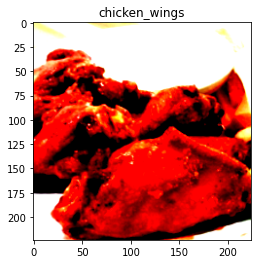

In [80]:
# ''' Sanity check. Check that you can visualize any image '''

img = test_ds[0]['pixel_values']
label = id2label[str(test_ds[0]['label'])]
print(type(img), img.max())

img_np = np.array(img.permute(1, 2, 0))
# plt.imshow(np.clip(img_np, a_min=0.0, a_max=1.0))
plt.imshow(img_np)
plt.title(label)

In [15]:
''' Define needed functions for later training '''

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'label': torch.tensor([x['label'] for x in batch])
    }

# data_collator = collate_fn
data_collator = DefaultDataCollator()

metric = datasets.load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

## Set training params

In [16]:
from transformers import TrainingArguments

batch_size = 32
learning_rate = 2e-4
epochs = 4

training_args = TrainingArguments(
    output_dir=checkpoint_model_folder,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="epoch",  # Can be steps or epoch
    save_strategy = "epoch",  # Must be the same as evaluation_strategy
    num_train_epochs=epochs,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=learning_rate,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
)

## Train

In [18]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Epoch,Training Loss,Validation Loss,Accuracy
1,1.000000,0.714238,0.818000
2,0.748400,0.447367,0.876000
3,0.646600,0.349273,0.906000
4,0.553500,0.328561,0.900000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 8
Saving model checkpoint to content/saved_models/checkpoint-125
Configuration saved in content/saved_models/checkpoint-125/config.json
Model weights saved in content/saved_models/checkpoint-125/pytorch_model.bin
Feature extractor saved in content/saved_models/checkpoint-125/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8
Saving model checkpoint to content/saved_models/checkpoint-250
Configuration saved in content/saved_models/checkpoint-250/config.json
Model weights saved in content/saved_models/checkpoint-250/pytorch_model.bin
Feature extractor saved in content/saved_models/checkpoint-250/preprocessor_config.json
Deleting older checkpoint [content/saved_models/checkpoint-125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8
Saving model checkpoint to content/saved_models/checkpoint-375
Configuration saved in content/saved_mo

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 375455580GF
  train_loss               =      0.9559
  train_runtime            =  0:09:43.72
  train_samples_per_second =       27.41
  train_steps_per_second   =       0.857


## Evaluate

In [19]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
# trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 500
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        0.9
  eval_loss               =      0.348
  eval_runtime            = 0:00:08.49
  eval_samples_per_second =     58.835
  eval_steps_per_second   =      7.413
